# 데이터 준비

28577_36420_compressed_fer2013.csv.zip 파일을 https://www.kaggle.com/deadskull7/fer2013 에서 다운 받은 후에 google drive의 tmp(미리 생성한)폴더에 올린다.


데이터 로딩하고 준비하는 코드는 https://github.com/SagarPatel98/Human-Facial-Emotion-Recognition---Keras/blob/master/Facial%20Recognition.ipynb 에서 가져왔다.

## 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/tmp/fer2013.csv.zip' ./

In [ ]:
!unzip fer2013.csv.zip

Archive:  fer2013.csv.zip
  inflating: fer2013.csv             


## 살펴보기

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from matplotlib.colors import ListedColormap
import seaborn as sns

import cv2

In [ ]:
df = pd.read_csv("fer2013.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
print(df.shape)

(35887, 3)


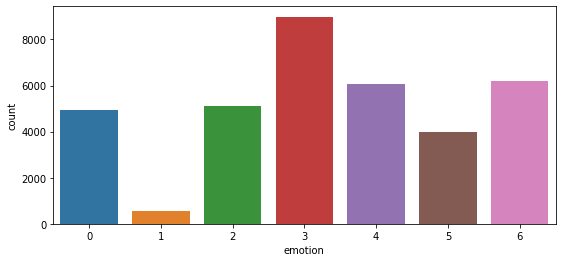

In [ ]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [ ]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

emotion 컬럼의 값은 다음을 의미.

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

1(disgust)의 수가 너무 적다.

0(angry)와 1(disgust)를 합친다.

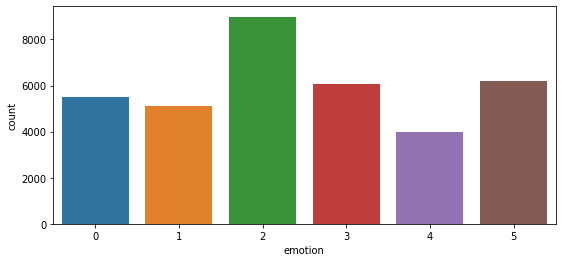

In [ ]:
df['emotion'] = df['emotion'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=df)

In [ ]:
category_names = [ "angry", "fear", "happy", "sad", "suprise", "neutral" ]

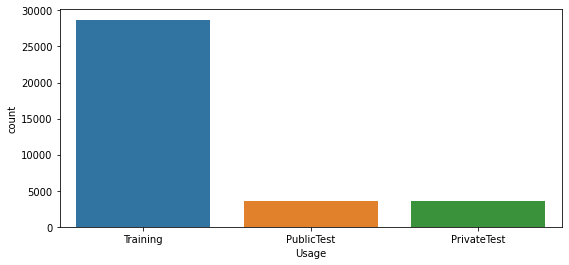

In [ ]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=df)

In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

## 얼굴 데이터 구하기

받은 csv파일에 얼굴 영상의 pixel 값이 숫자로 그냥 들어 있다.
이를 읽어서 데이터를 준비하자.

In [ ]:
image_size=(48,48)

In [ ]:
pixels = df['pixels'].tolist()
width, height = 48, 48
faces = []

for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(width, height)
  face = cv2.resize(face.astype('uint8'),image_size)
  faces.append(face.astype('float32'))
  
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
print(faces.shape)

(35887, 48, 48, 1)


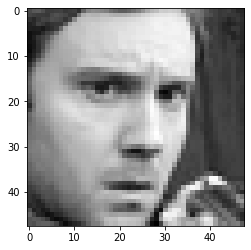

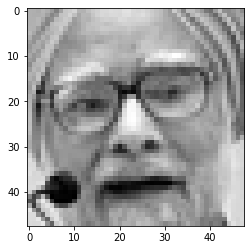

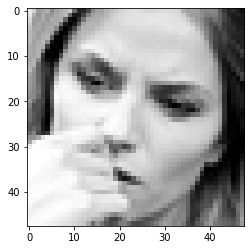

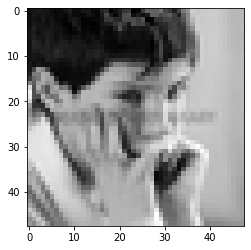

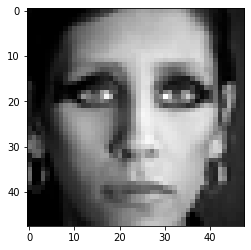

In [ ]:
for i in range(5):
    plt.imshow(faces[i].squeeze(), cmap="gray")
    plt.show()

## Normalization

In [ ]:
print(np.min(faces), np.max(faces))
faces = faces / 255.0
print(np.min(faces), np.max(faces))

0.0 255.0
0.0 1.0


## emotion 데이터 구하기

In [ ]:
emotions = df['emotion'].values
print(emotions.shape)
print(emotions)

(35887,)
[0 0 1 ... 0 2 1]


## 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(faces, emotions, test_size=0.2)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


# 모델 정의

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPool2D, Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


model = keras.Sequential()

model.add(Input(train_x.shape[1:]))
model.add(Conv2D(32, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])



# 데이터 증강

In [ ]:
train_data_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      vertical_flip=False,
)

test_data_generator = ImageDataGenerator()

# 학습

In [ ]:
model.fit(
      train_data_generator.flow(train_x, train_y, 32),
      validation_data=test_data_generator.flow(test_x, test_y, 32),
      steps_per_epoch=len(train_x)/32,  
      validation_steps=len(test_x)/32,      
      epochs=10
)

Epoch 1/10
897/897 [==============================] - 23s 13ms/step - loss: 1.6885 - acc: 0.3214 - val_loss: 1.4407 - val_acc: 0.4238
Epoch 2/10
897/897 [==============================] - 12s 13ms/step - loss: 1.5103 - acc: 0.3975 - val_loss: 1.4250 - val_acc: 0.4487
Epoch 3/10
897/897 [==============================] - 11s 13ms/step - loss: 1.4627 - acc: 0.4245 - val_loss: 1.3239 - val_acc: 0.4897
Epoch 4/10
897/897 [==============================] - 11s 12ms/step - loss: 1.4322 - acc: 0.4370 - val_loss: 1.3059 - val_acc: 0.4933
Epoch 5/10
897/897 [==============================] - 11s 13ms/step - loss: 1.4174 - acc: 0.4456 - val_loss: 1.2861 - val_acc: 0.5050
Epoch 6/10
897/897 [==============================] - 11s 13ms/step - loss: 1.4131 - acc: 0.4497 - val_loss: 1.3249 - val_acc: 0.4993
Epoch 7/10
897/897 [==============================] - 11s 12ms/step - loss: 1.4060 - acc: 0.4494 - val_loss: 1.4206 - val_acc: 0.4689
Epoch 8/10
897/897 [==============================] - 11s 13ms

In [ ]:
model.fit(
      train_data_generator.flow(train_x, train_y, 32),
      validation_data=test_data_generator.flow(test_x, test_y, 32),
      steps_per_epoch=len(train_x)/32,  
      validation_steps=len(test_x)/32,      
      epochs=40
)

Epoch 1/40
897/897 [==============================] - 11s 13ms/step - loss: 1.4027 - acc: 0.4566 - val_loss: 1.2882 - val_acc: 0.5169
Epoch 2/40
897/897 [==============================] - 11s 12ms/step - loss: 1.4120 - acc: 0.4535 - val_loss: 1.2854 - val_acc: 0.5109
Epoch 3/40
897/897 [==============================] - 11s 13ms/step - loss: 1.4195 - acc: 0.4481 - val_loss: 1.3690 - val_acc: 0.4836
Epoch 4/40
897/897 [==============================] - 11s 13ms/step - loss: 1.4070 - acc: 0.4568 - val_loss: 1.2933 - val_acc: 0.5270
Epoch 5/40
897/897 [==============================] - 11s 13ms/step - loss: 1.4250 - acc: 0.4496 - val_loss: 1.2785 - val_acc: 0.5084
Epoch 6/40
897/897 [==============================] - 11s 12ms/step - loss: 1.4357 - acc: 0.4463 - val_loss: 1.3031 - val_acc: 0.5116
Epoch 7/40
897/897 [==============================] - 11s 13ms/step - loss: 1.4386 - acc: 0.4460 - val_loss: 1.3837 - val_acc: 0.4992
Epoch 8/40
897/897 [==============================] - 11s 12ms

# 평가

In [ ]:
loss, acc = model.evaluate(
      test_data_generator.flow(test_x, test_y, 32),
      steps=len(test_x)/32
)
print(loss, acc)

224/224 [==============================] - 1s 2ms/step - loss: 1.2988 - acc: 0.4989
1.2987947463989258 0.49888548254966736


# 결과 보기

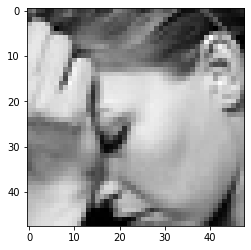

predicted category index = 1
fear


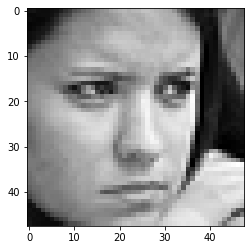

predicted category index = 5
neutral


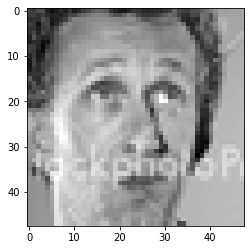

predicted category index = 2
happy


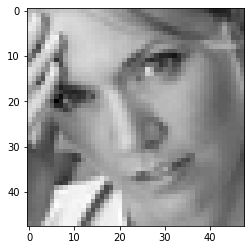

predicted category index = 3
sad


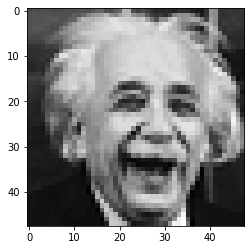

predicted category index = 0
angry


In [ ]:
y_ = model.predict(test_x)

predicted = np.argmax(y_, axis=1)

for i in range(5):
  plt.imshow(test_x[i].squeeze(), cmap="gray")
  plt.show()
  print("predicted category index =", predicted[i])
  print(category_names[predicted[i]])


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predicted)
print(cm)

[[ 412   54  169  189    9  262]
 [ 190  221  142  187   74  190]
 [  92   37 1372  138    7  156]
 [ 161   50  204  497   11  315]
 [  59  152  101   36  369   83]
 [ 103   36  172  212    6  710]]


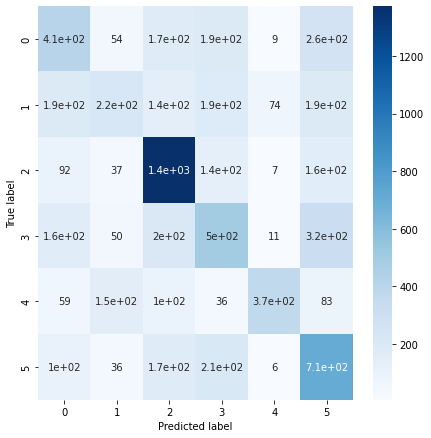

In [ ]:
import seaborn as sns

figure = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# category_names = [ "angry", "fear", "happy", "sad", "suprise", "neutral" ]

In [ ]:
!nvidia-smi

Tue Jul  5 02:44:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    39W / 300W |   1377MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 보고서 작성 예
```
보고서

	개요
		어떤 데이터, 어떤 모델, 어떤 작업, 결과
		흑백 얼굴 영상을 CNN으로 학습하여 6가지 감정을 분류하는 작업을 진행하였다.
		정확도는 49%였다.

	데이터 전처리
		kaggle xxx에서 데이터를 다운로드 받았다.
		0~1 의 값으로 normalization하였다.
		48x48의 크기로 리사이즈.

		데이터는 총 35,887개 였으며, train 데이터화 test 데이터를 8:2로 나누었다.
		valid 데이터는 따로 두지 않고 test 데이터로 사용하였다.

	모델 구조
		CNN을 사용. 필터 크기는 3x3, 
		conv(필터 32개) - max pooling - conv(필터 64개) - max pooling 
		- flatten - FC(노드 1024개) - dropout - output의 구조.

	학습 상세
		Keras를 사용. Colab에서 GPU Tesla V100-SXM2 사용.
		손실함수는 crossentropy, optimizer는 Adam, batch size는 32.
		50 에폭 학습. 총 10분 소요.

	결과
		로스 그래프, 정확도 그래프
		테스트 데이터에 대한 정확도는 49.9%
		ROC 그래프
		혼돈 그래프
		AUC는 xxx

	결론
		49%의 정확도로 높지 않았다.
		특정 카테고리로 편중되는 것 같지는 않다.
		모델 구조를 개선하여 성능을 높일 수 있을 것 같다.
```